# Install Torchtext

In [1]:
# !pip install torchtext

# Environment

In [2]:
import sys
import pandas as pd
import spacy

from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

import torchtext
from torchtext import data
from torchtext import vocab

In [3]:
print('Python version:',sys.version)
print('Pandas version:',pd.__version__)
print('Pytorch version:', torch.__version__)
print('Torch Text version:', torchtext.__version__)
print('Spacy version:', spacy.__version__)

Python version: 3.7.4 (default, Aug 13 2019, 20:35:49) 
[GCC 7.3.0]
Pandas version: 0.25.1
Pytorch version: 1.3.1
Torch Text version: 0.4.0
Spacy version: 2.2.3


# Tokenizer

In [4]:
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [5]:
NLP = spacy.load('en', disable=['parser', 'tagger', 'ner'])
# max_len = 130

In [6]:
remove_marks_regex = re.compile("[,\.\(\)\[\]\*:;]|<.*?>")
remove_links_regex = re.compile("https?:/\/\S+")
# shift_marks_regex = re.compile("([?!])")

In [7]:
def tokenizer(text):
    
    text = text.strip()
#     print(text)
    
    # removing symbol except for !?
    text = remove_marks_regex.sub("", text)
    # removing link
    text = remove_links_regex.sub("", text)
    # inserting blank space between !? and words
#     text = shift_marks_regex.sub(r" \1 ", text)
    
#     print(text)
    
    doc = NLP(text)
    sequences = [token.text.lower() for token in doc]
    
#     if len(sequences) > max_len:
#         sequences = sequences[:max_len]
    
#     print(sequences)
    
    return sequences

In [8]:
tokenizer("   Feeeling like shit right now. I really want to sleep, but nooo I have 3 hours of dancing and an art assignment to finish. ")

['feeeling',
 'like',
 'shit',
 'right',
 'now',
 'i',
 'really',
 'want',
 'to',
 'sleep',
 'but',
 'nooo',
 'i',
 'have',
 '3',
 'hours',
 'of',
 'dancing',
 'and',
 'an',
 'art',
 'assignment',
 'to',
 'finish']

# Load Data

In [9]:
BASIC_PATH = './'

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
df = pd.read_csv(BASIC_PATH + 'Sentiment_Analysis_Dataset.csv', delimiter = ',', skiprows = 1,
                   names = ['ItemID', 'Sentiment', 'SentimentSource', 'SentimentText'],
                   usecols=['Sentiment', 'SentimentText'])

In [12]:
df

,Sentiment,SentimentText
0,0,is so sad for my APL frie...
1,0,I missed the New Moon trail...
2,1,omg its already 7:30 :O
3,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,0,i think mi bf is cheating on me!!! ...
...,...,...
1578609,1,Zzzzzz.... Finally! Night tweeters!
1578610,1,"Zzzzzzz, sleep well people"
1578611,0,ZzzZzZzzzZ... wait no I have homework.
1578612,0,"ZzZzzzZZZZzzz meh, what am I doing up again?"


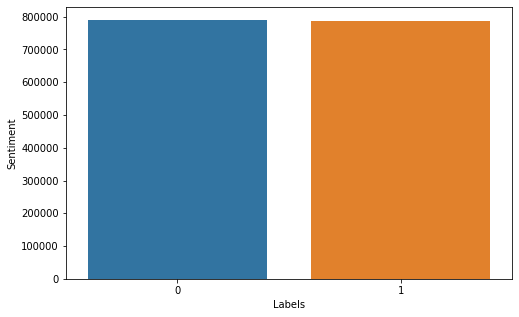

In [13]:
fig = plt.figure(figsize=(8,5))
ax = sns.barplot(x=df.Sentiment.unique(),y=df.Sentiment.value_counts());
ax.set(xlabel='Labels');

# Split Train & Validation

In [14]:
test_size = 0.2

In [15]:
traindf, valdf = train_test_split(df, test_size=test_size,random_state=42)

In [16]:
traindf

,Sentiment,SentimentText
1444927,1,I like musical comedies
1041155,1,@MartiniMisty I'll take Italian Job Norton. Oh...
1002675,1,@lizzylou62 Good luck with the exams!
1370189,1,Alyssa_Milano Just wanted to say I love your w...
610934,0,Chinese for lunch wasn't a very bright idea! I...
...,...,...
259178,1,@kristinbickel you should be at youth group!!...
1414414,0,got burned b/c she is stupid and forgot to sun...
131932,1,@Domm_LoveLife if you like 2 laugh..have a go...
671155,0,@bunchesxx omg i second that i'm pretty much ...


In [17]:
traindf.Sentiment.value_counts()

1    632378
0    630513
Name: Sentiment, dtype: int64

In [18]:
valdf

,Sentiment,SentimentText
1432703,1,http://www.popsugar.com/2999655 keep voting fo...
166675,1,@GamrothTaylor I am starting to worry about yo...
1224710,0,sunburned...no sunbaked! ow. it hurts to sit.
606184,1,Celebrating my 50th birthday by doing exactly ...
1487194,1,Leah and Aiden Gosselin are the cutest kids on...
...,...,...
1254101,1,@SteffNasty LOLOL @ Spaceships maybe the futur...
978908,0,Jus in work wi jenivivo miss my baby tho xxx...
301363,1,@Mds0221 nothing much you?
1140075,0,OMG Freakin dropped my Freakin iPOD! I'm sad c...


In [19]:
valdf.Sentiment.value_counts()

0    157923
1    157800
Name: Sentiment, dtype: int64

In [20]:
traindf.to_csv(BASIC_PATH + 'traindf.csv', index=False)
valdf.to_csv(BASIC_PATH + 'valdf.csv', index=False)

# Torchtext Field

- http://torchtext.readthedocs.io/en/latest/data.html#fields

In [21]:
max_len = 512

In [22]:
txt_field = data.Field(sequential=True,  # for sequence data like sentence, set this argument True
             use_vocab=True,
             fix_length = max_len,
             tokenize=tokenizer, #tokenize=str.split,  # you can define your own tokenizer
             include_lengths=True,
             lower=True, 
             batch_first=True)  
label_field = data.Field(sequential=False,  # for non-sequence data like label, set this argument False
              use_vocab=False,   # since label is a number, we don't have to use vocabulary
              fix_length = max_len,
#               preprocessing = lambda x: int(x),  # this preprocessing is used after Tokenize and before Numericalize
              batch_first=True)

In [23]:
# [(필드이름, 필드객체), ...]

train_val_fields = [
#     ('ItemID', None),
    ('Sentiment', label_field),
#     ('SentimentSource', None),
    ('SentimentText', txt_field)
]

# TabularDataset

In [24]:
from torchtext.data import TabularDataset, Iterator

In [25]:
%%time
trainDataset, validDataset = TabularDataset.splits(path=BASIC_PATH,
                                   format='csv',
                                   train='traindf.csv',
                                   validation='valdf.csv',
                                   fields=train_val_fields,
                                   skip_header=True)

CPU times: user 4min 17s, sys: 1.7 s, total: 4min 19s
Wall time: 4min 19s


In [26]:
len(trainDataset)

1262891

In [27]:
len(validDataset)

315723

In [28]:
trainDataset.fields.items()

dict_items([('Sentiment', <torchtext.data.field.Field object at 0x7fbddaf1a6d0>), ('SentimentText', <torchtext.data.field.Field object at 0x7fbddaf1a690>)])

In [29]:
trainDataset[0].SentimentText

['i', 'like', 'musical', 'comedies']

In [30]:
trainDataset[0].Sentiment

'1'

In [31]:
validDataset.fields.items()

dict_items([('Sentiment', <torchtext.data.field.Field object at 0x7fbddaf1a6d0>), ('SentimentText', <torchtext.data.field.Field object at 0x7fbddaf1a690>)])

In [32]:
validDataset[0].SentimentText

['http//wwwpopsugarcom/2999655',
 'keep',
 'voting',
 'for',
 'robert',
 'pattinson',
 'in',
 'the',
 'popsugar100',
 'as',
 'well',
 '!',
 '!']

In [33]:
validDataset[0].Sentiment

'1'

# Vocab

- Load pretrained word vectors

In [34]:
max_size=100000

In [35]:
%%time
txt_field.build_vocab(trainDataset, validDataset, max_size=max_size)
label_field.build_vocab(trainDataset)

CPU times: user 10.1 s, sys: 63.9 ms, total: 10.1 s
Wall time: 10.1 s


In [36]:
len(txt_field.vocab)

100002

In [37]:
txt_field.vocab.stoi['<unk>']

0

In [38]:
txt_field.vocab.stoi['<pad>']

1

In [39]:
txt_field.vocab.stoi['answer']

848

# Batch

In [40]:
BATCH_SIZE = 512

In [41]:
train_loader = Iterator(trainDataset, 
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        device="cuda",  # "cuda" or None
                        repeat=False)

In [42]:
valid_loader = Iterator(validDataset, 
                        batch_size=BATCH_SIZE,
                        shuffle=False,
                        device="cuda",  # "cuda" or None
                        repeat=False)

In [43]:
for batch in train_loader:
    break
print(batch.SentimentText[0])
print(batch.SentimentText[0].shape)
print(batch.SentimentText[1])
print(batch.Sentiment)

tensor([[ 2664,   165, 10228,  ...,     1,     1,     1],
        [ 1790,     6,   843,  ...,     1,     1,     1],
        [    6,     0,    16,  ...,     1,     1,     1],
        ...,
        [  494,     5,    21,  ...,     1,     1,     1],
        [   27,    47,    95,  ...,     1,     1,     1],
        [    0,    10,    31,  ...,     1,     1,     1]], device='cuda:0')
torch.Size([512, 512])
tensor([21,  9, 27, 12, 29, 16, 18,  8, 15, 27, 20, 10, 19, 30,  8, 19, 13, 14,
        24, 16,  6, 28, 13, 22,  9, 25, 30,  6, 28,  9, 13,  7,  8, 15, 15, 12,
         5, 19, 14, 18, 33, 34, 27, 12, 27, 15, 19, 18, 14, 14, 22, 25, 19, 11,
         4, 26, 24, 10, 21, 15, 24, 21, 21, 21, 27, 22,  9, 32, 26, 16, 15, 21,
         7, 11,  6,  4,  6, 16, 24, 12, 20, 14, 30,  4, 11, 15, 19, 12,  5, 26,
        11, 12,  3, 30,  5, 25, 15, 10, 26,  5, 16,  7,  5,  8, 23, 15,  1, 27,
        28, 16, 20,  7, 15, 22, 10,  4, 11,  5, 25,  7,  4, 38, 16, 15, 16, 23,
         6,  4, 26,  4, 20,  7, 28, 15

In [44]:
for batch in valid_loader:
    break
print(batch.SentimentText[0])
print(batch.SentimentText[0].shape)
print(batch.SentimentText[1])
print(batch.Sentiment)

tensor([[    0,   257,  2182,  ...,     1,     1,     1],
        [    0,     2,    63,  ...,     1,     1,     1],
        [    0,     0,     3,  ...,     1,     1,     1],
        ...,
        [   55,    19,    46,  ...,     1,     1,     1],
        [26945,  4753,  4030,  ...,     1,     1,     1],
        [ 1715,     6,   269,  ...,     1,     1,     1]], device='cuda:0')
torch.Size([512, 512])
tensor([13, 16, 10, 26, 14,  7, 20, 26,  6, 10, 17, 21,  5, 22, 12, 27, 35, 31,
        15, 13, 12,  8,  5, 16, 19,  4, 10, 26,  4, 19, 27, 20, 13, 30, 22, 11,
        15, 13, 13, 11,  9,  8, 24, 28, 28, 11, 24, 19, 26, 19, 24, 31,  5, 11,
        11, 19,  7,  8, 15, 22, 24, 26, 13, 18, 11,  8,  4,  9,  6, 13,  4, 25,
         2, 12,  7, 20, 10, 11, 14, 14, 21, 22, 19, 25,  9, 11, 22, 31, 26, 18,
        27, 17, 16,  4, 32, 23,  4, 12, 25,  7, 12,  2, 23, 10, 10, 30, 17, 24,
        28,  4, 10, 20, 13, 16,  6,  4, 30, 15, 20,  5,  8,  4, 13, 18,  9, 15,
        10, 21, 20, 11, 26, 11, 27,  3